<a href="https://colab.research.google.com/github/Skillerx27/Image_Classification_Using_Deep_Learning/blob/master/mnist_digit_using_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import Dense, Conv2D, Activation, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
import keras
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import cv2
from keras import backend as K
import tensorflow as tf
color = sns.color_palette()

%matplotlib inline

In [2]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 2s 0us/step


In [3]:
print(X_train.shape)
print(y_train.shape)

(60000, 28, 28)
(60000,)


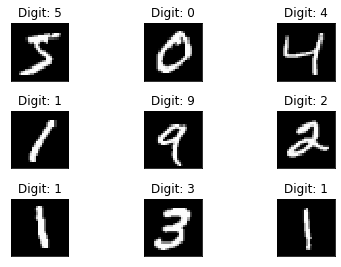

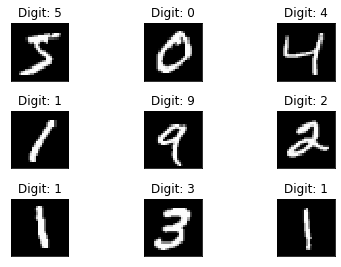

In [4]:
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(X_train[i], cmap='gray', interpolation='none')
  plt.title("Digit: {}".format(y_train[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [0]:
train_info = []
for i in range(60000):
  train_info.append((X_train[i],int(y_train[i])))

In [6]:
train_info = pd.DataFrame(train_info, columns=['image', 'label'],index=None)
train_info.head()

,image,label
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",5
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",9


1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
Name: label, dtype: int64


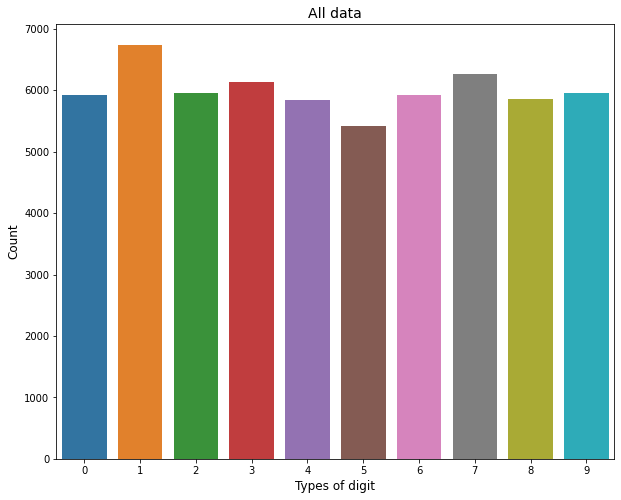

In [7]:
# Get the counts for each class
cases_count = train_info['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('All data', fontsize=14)
plt.xlabel('Types of digit', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['0','1','2','3','4','5','6','7','8','9'])
plt.show()

In [0]:
X_train = X_train.reshape((-1, 28, 28, 1))
X_test = X_test.reshape((-1, 28, 28, 1))
X_train = X_train/255.0
X_test = X_test/255.0

In [0]:
model = Sequential()

#1. LAYER
model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same', input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(Activation("relu"))

#2. LAYER
model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same'))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(MaxPool2D(pool_size=(2, 2)))

#3. LAYER
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same'))
model.add(BatchNormalization())
model.add(Activation("relu"))

#4. LAYER
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same'))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(MaxPool2D(pool_size=(2, 2)))

#FULLY CONNECTED LAYER
model.add(Flatten())
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.25))

#OUTPUT LAYER
model.add(Dense(10, activation='softmax'))

In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)       

In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []

    def on_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])

batch_stats = CollectBatchStats()

In [13]:
reduce_lr = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
aug_num = 10 
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range= 0.8,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = aug_num / 100, # Randomly zoom image 
        width_shift_range= aug_num / 100,  # randomly shift images horizontally (fraction of total width)
        height_shift_range= aug_num / 100,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=0.05,  # randomly flip images horizontally
        vertical_flip=True)  # randomly flip images vertically
        
datagen.fit(X_train)
batch_size = 128
epochs =  30
# Fit the Model
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size), epochs = epochs, 
                              validation_data = (X_test, y_test), verbose=2, 
                              steps_per_epoch=X_train.shape[0] // batch_size,
                              callbacks=[reduce_lr])

Epoch 1/30
 - 34s - loss: 0.4066 - accuracy: 0.8656 - val_loss: 3.8753 - val_accuracy: 0.2895
Epoch 2/30
 - 28s - loss: 0.2034 - accuracy: 0.9334 - val_loss: 0.2009 - val_accuracy: 0.9349
Epoch 3/30
 - 27s - loss: 0.1699 - accuracy: 0.9433 - val_loss: 0.1210 - val_accuracy: 0.9619
Epoch 4/30
 - 27s - loss: 0.1519 - accuracy: 0.9496 - val_loss: 0.1644 - val_accuracy: 0.9471
Epoch 5/30
 - 27s - loss: 0.1401 - accuracy: 0.9535 - val_loss: 0.1115 - val_accuracy: 0.9634
Epoch 6/30
 - 27s - loss: 0.1338 - accuracy: 0.9552 - val_loss: 0.1494 - val_accuracy: 0.9509
Epoch 7/30
 - 27s - loss: 0.1227 - accuracy: 0.9598 - val_loss: 0.1411 - val_accuracy: 0.9504
Epoch 8/30
 - 27s - loss: 0.1159 - accuracy: 0.9615 - val_loss: 0.0935 - val_accuracy: 0.9686
Epoch 9/30
 - 27s - loss: 0.1120 - accuracy: 0.9622 - val_loss: 0.1090 - val_accuracy: 0.9628
Epoch 10/30
 - 28s - loss: 0.1058 - accuracy: 0.9643 - val_loss: 0.1180 - val_accuracy: 0.9600
Epoch 11/30
 - 28s - loss: 0.1029 - accuracy: 0.9643 - val_

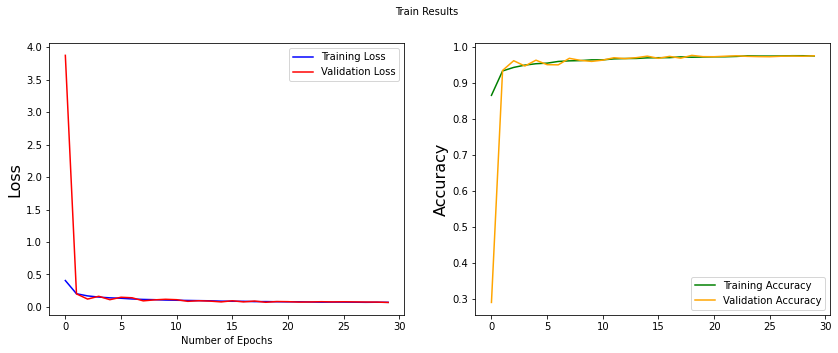

In [14]:
plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1)
plt.suptitle('Train Results', fontsize=10)
plt.xlabel("Number of Epochs")
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], color='b', label='Training Loss')
plt.plot(history.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], color='green', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [15]:
print('Train accuracy of the model: ',history.history['accuracy'][-1])

Train accuracy of the model:  0.9751136


In [16]:
print('Train loss of the model: ',history.history['loss'][-1])

Train loss of the model:  0.07093283505179486


In [17]:
print('Validation accuracy of the model: ',history.history['val_accuracy'][-1])

Validation accuracy of the model:  0.975600004196167


In [18]:

print('Validation loss of the model: ',history.history['val_loss'][-1])

Validation loss of the model:  0.06922212003171443


In [19]:
score = model.evaluate(X_test,y_test,verbose=0)
print("Test Loss:",score[0])
print("Test Accuracy:",score[1])

Test Loss: 0.06922212151885032
Test Accuracy: 0.975600004196167


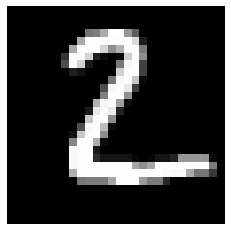

In [21]:
plt.imshow(X_test[1].reshape(28,28),cmap="gray")
plt.axis("off")
plt.show()

In [23]:
trueY = y_test[1]
img = X_test[1]
test_img = img.reshape(1,28,28,1)

preds = model.predict_classes(test_img)
prob = model.predict_proba(test_img)

print("trueY: ",np.argmax(trueY))
print("Preds: ",preds)
print("Prob: ",prob)

trueY:  0
Preds:  [2]
Prob:  [[1.3092156e-06 6.7998343e-07 9.8362666e-01 4.9070309e-07 3.8953479e-10
  1.5148626e-02 6.2596218e-06 1.2153889e-03 1.1991613e-08 5.7843113e-07]]


In [24]:
from keras.utils.np_utils import to_categorical 

# convert to one-hot-encoding(one hot vectors)
Y_train = to_categorical(y_train, num_classes = 10)
# convert to one-hot-encoding(one hot vectors)
Y_test = to_categorical(y_test, num_classes = 10)

print(Y_train.shape)
print(Y_test.shape)

(60000, 10)
(10000, 10)


In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

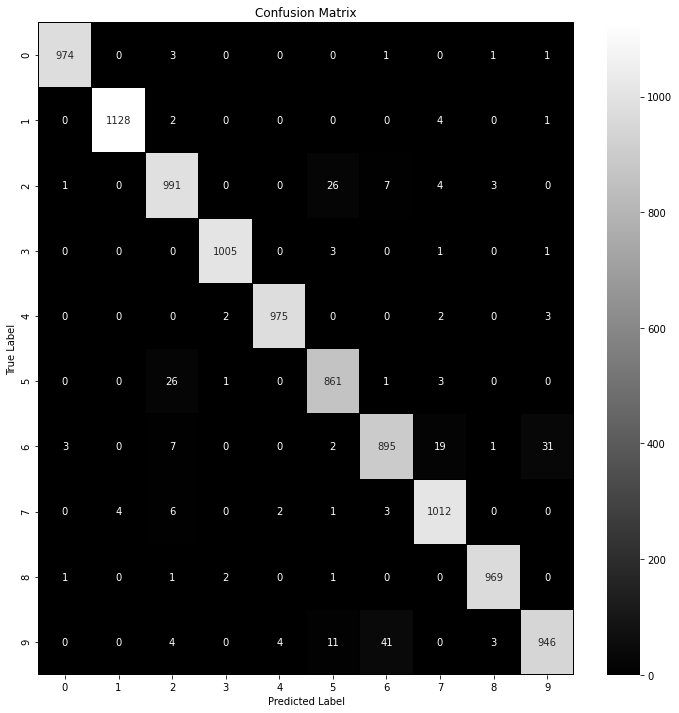

In [27]:
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis = 1)
Y_true = np.argmax(Y_test, axis = 1)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

f,ax = plt.subplots(figsize = (12,12))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.1, cmap = "gist_yarg_r", linecolor="black", fmt='.0f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [0]:
model.save('digit.h5')